---
## Import packages

In [ ]:
from art import*
art= text2art ("Let 's     Go    !!!")
print(art)

 _            _     _             ____             _  _  _ 
| |      ___ | |_  ( ) ___       / ___|  ___      | || || |
| |     / _ \| __| |/ / __|     | |  _  / _ \     | || || |
| |___ |  __/| |_     \__ \     | |_| || (_) |    |_||_||_|
|_____| \___| \__|    |___/      \____| \___/     (_)(_)(_)
                                                           



In [3]:
pip install art 
!pip install farasapy
!pip install Tashaphyne==0.3.4.1
!pip install wordcloud
!pip install ar_wordcloud
import nltk
nltk.download('stopwords')
nltk.download('punkt')

     |████████████████████████████████| 244 kB 9.0 MB/s 
     |████████████████████████████████| 126 kB 35.9 MB/s 
     |████████████████████████████████| 366 kB 14.2 MB/s 
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.5.0
    Uninstalling wordcloud-1.5.0:
      Successfully uninstalled wordcloud-1.5.0
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [4]:
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

import matplotlib as mpl
import matplotlib.pyplot as plt

import string

import re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
# from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

from ar_wordcloud import ArabicWordCloud

In [5]:
from tashaphyne.stemming import ArabicLightStemmer

In [6]:
import nltk
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
from nltk.stem.isri import ISRIStemmer

In [7]:
from farasa.pos import FarasaPOSTagger
from farasa.ner import FarasaNamedEntityRecognizer
from farasa.diacratizer import FarasaDiacritizer
from farasa.segmenter import FarasaSegmenter
from farasa.stemmer import FarasaStemmer

---
## Read and exploring the data

In [10]:
df = pd.read_csv('SaudiNews')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df

,source,title,content
0,aleqtisadiya,هيئة المسح الجيولوجي الأمريكية: زلزال بقوة 6.3...,قالت هيئة المسح الجيولوجي الأمريكيةإن زلزالا ...
1,alweeam,توفر وظائف أكاديمية بجامعــة الملك فيصل,أعلنت جامعة الملك فيصل بالأحساء توفر عدد من ا...
2,sabq,&quot;أدبي جدة&quot; يدشن دورة &quot;مفاهيم كت...,سبق- جدة: دشَّن أدبي جدة اللقاء الأول من دورة...
3,alyaum,قتلة الطموح,«في مجتمعنا مبدأ يمنع تطور الفرد فكرياً واجتم...
4,alriyadh,دراسة مسببات عدم انخفاض السلع في المملكة بانخف...,أكد الدكتور سليمان السماحي الرئيس التنفيذي...
...,...,...,...
9995,okaz,تطويق العنف المدرسي ببرنامج «رفق» الإرشادي,تعتزم وزارة التعليم، في مستهل العام الدراسي ا...
9996,aawsat,ولي ولي العهد السعودي يتقبل بيعة منسوبي وزارة...,استقبل الأمير محمد بن سلمان بن عبد العزيز ولي ...
9997,alriyadh,هبوط أول طائرة عسكرية سعودية في مطار عدن بعد د...,هبطت طائرة عسكرية سعودية في مطار مدينة عدن...
9998,alwatan,"استثمار ""الربيعة"" عالميا",هناك دول في العالم تنفق مع شركات علاقات عالمي...


In [11]:
df = pd.read_csv('SaudiNews')
df.drop(columns= ['Unnamed: 0'], inplace= True)
df_sample=df.sample(n = 3000)

In [24]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 1094 to 3958
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   source   3000 non-null   object
 1   title    2995 non-null   object
 2   content  2986 non-null   object
dtypes: object(3)
memory usage: 93.8+ KB


In [25]:
df_sample.duplicated().sum()

11

In [26]:
df_sample.drop_duplicates(inplace = True)

---
## NLP Preprocessing

In [27]:
max(df_sample.content.str.len())

21130.0

In [28]:
min(df_sample.content.str.len())

1.0

**removing observtions less than 120**

In [29]:
df_sample = df_sample[df_sample.content.str.len() > 120]

In [30]:
df_sample.shape

(2927, 3)

In [31]:
df_sample.content.isna().sum()

0

### **Removing Non-arabic letters, numbers, amiss typo and special characters**

In [32]:
# function to clean and normalize text 
def clean_text(text):
    search = ["أ","إ","آ","ة","_","-","/",".","،"," و "," يا ",'"',"ـ","'","ى","\\",'\n', '\t','&quot;','?','؟','!']
    replace = ["ا","ا","ا","ه"," "," ","","",""," و"," يا","","","","ي","",' ', ' ',' ',' ? ',' ؟ ',' ! ']  
    p_tashkeel = re.compile(r'[\u0617-\u061A\u064B-\u0652]')
    text = re.sub(p_tashkeel,"", text)
    p_longation = re.compile(r'(.)\1+')
    subst = r"\1\1"
    text = re.sub(p_longation, subst, text)
    text = text.replace('وو', 'و')
    text = text.replace('يي', 'ي')
    text = text.replace('اا', 'ا')
    
    for i in range(0, len(search)):
        text = text.replace(search[i], replace[i])
        
    text = text.strip()
    
    return text

In [33]:
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation
punctuations_list = arabic_punctuations + english_punctuations

arabic_diacritics = re.compile("""
                             ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)


def normalize_arabic(text):
    text = re.sub("[إأآا]", "ا", text)
    text = re.sub("ى", "ي", text)
    text = re.sub("ؤ", "ء", text)
    text = re.sub("ئ", "ء", text)
    text = re.sub("ة", "ه", text)
    text = re.sub("گ", "ك", text)
    
    return text


def remove_diacritics(text):
    text = re.sub(arabic_diacritics, '', text)
    return text


def remove_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)


def remove_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [34]:
# clean and normalize text
df_sample['content'] = df_sample.content.apply(lambda x: clean_text(x))

# remove punctuation
df_sample['content'] = df_sample.content.apply(lambda x: remove_punctuations(x))

# remove diacritics
df_sample['content'] = df_sample.content.apply(lambda x: remove_diacritics(x))

# remove repeating char
df_sample['content'] = df_sample.content.apply(lambda x: remove_repeating_char(x))

# remove english letters
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'[a-zA-Z]', '', x))

# remove a special character _
df_sample.content = df_sample.content.apply(lambda x: re.sub(r'[_]+', '', x))

# remove space
df_sample['content'] = df_sample.content.str.replace('\d+', '')

In [35]:
df_sample

,source,title,content
1094,alriyadh,طالب سعودي يفوز بجائزة الجامعات الأميركية,حق الطالب سعود بن فهد الزيد تميزا علي مستوي ال...
6664,alriyadh,أيام العيد.. مرضى السكري مؤهلون لقضائها في رده...,العيد ايام معدودات ويفترض ان يكون شهر العيد هو...
5554,almadina,"أمير مكة يرعى معرض ""الفيصل ..شاهد وشهيد"" بالطائف",يرعي صاحب السمو الملكي الامير خالد الفيصل مستش...
6473,alweeam,بالصور..مدير الأمن العام يطلع على مجريات التحق...,نقل معالي مدير الامن العام الفريق الركن عثمان ...
891,alriyadh,أمير منطقة القصيم يشكر وزير الشؤون الإسلامية,اعرب صاحب السمو الملكي الامير الدكتور فيصل بن ...
...,...,...,...
5823,aljazirah,ميشن امبوسيبل يحافظ على صدارة إيرادات السينما ...,حافظ الجزء الجديد من افلام المغامرات والحركه م...
6098,aljazirah,سبقك بها أوباما يا «جندل»!,برز منذ سنوات نجم سياسي امريكي من اصل هندي اسم...
3830,alwatan,البحرين خط أحمر يا إيران,عندما بدا المستعمر البريطاني في نهايه ستينيات ...
1798,3alyoum,إيران تستأنف تصدير الغاز إلى تركيا,دبي عين اليوم قالت وكاله انباء وزاره النفط الا...


In [36]:
# Convert to list
data = df_sample[df_sample.columns[2]].values.tolist()

### **Stemming**

In [37]:
farasa_st = FarasaStemmer()

100%|██████████| 241M/241M [00:24<00:00, 9.90MiB/s]


In [46]:
# st = ISRIStemmer()
# ArListem = ArabicLightStemmer()

# def stemSentence(sentence):
#     token_words=word_tokenize(sentence)
#     stem_sentence=[]
#     for word in token_words:
#         stem_sentence.append(farasa_st.stem(word))
#         #stem_sentence.append(ArListem.light_stem(word))
#         stem_sentence.append(' ')
#     return "".join(stem_sentence)

# df.content = df.content.apply(lambda x: stemSentence(x))

### **TF-IDF Vectorizer**

In [38]:
# the document-term matrix 
arb_stopwords = set(nltk.corpus.stopwords.words('arabic'))
tfidf = TfidfVectorizer(stop_words=arb_stopwords)
doc_words = tfidf.fit_transform(df_sample.content)
pd.DataFrame(doc_words.toarray(),columns=tfidf.get_feature_names())

,اؤدي,اؤكد,اؤلئك,اؤيد,ائتلاف,ائتلافيه,ائتمانيه,ائمه,اب,ابا,اباء,اباؤهم,ابائه,ابائهم,ابابا,اباتش,اباحسين,اباحي,اباحيا,اباد,اباده,ابار,ابارا,ابارك,اباغسطس,ابالغ,ابان,ابانات,ابانت,ابانمي,اباه,اباها,اباوت,ابت,ابتد,ابتدا,ابتداء,ابتدائي,ابتدائيه,ابتدات,...,ﺑﻌﺪ,ﺑﻤثل,ﺗﻮﻏﻞ,ﺣﺎﻟﻴﺎ,ﺣﺘﻰ,ﺩﺍﺭ,ﺩﺭﺍﺳﺔ,ﺳنقطعه,ﺳﺘﻮﺍﺻﻞ,ﻋﻤﻠﻴﺎﺗﻬﺎ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻓﻲ,ﻗﺎﻝ,ﻛﺎﻥ,ﻛﻞ,ﻟﻌﻮﺩﺓ,ﻟﻠﺘﺤﺎﻟﻒ,ﻟﻠﺮﺋﻴﺲ,ﻣنطقه,ﻣﺠﺎﻝ,ﻣﺤﺮﺭﺓ,ﻣﺪﺭﻋﺎﺕ,ﻣﺴﺆﻭﻝ,ﻣﺴﺎﻋﺪﺍﺕ,ﻣﺼﺪﺭ,ﻣﻊ,ﻣﻦ,ﻭان,ﻭﺍﺳﺘﻘﺒﺎﻝ,ﻭﺍﻟﻤﺸروعات,ﻭﺍﻟﻤﻮﺍﻧﺊ,ﻭﺯﻳري,ﻭﻣﺴﺘﻘﺮﺓ,ﻭﻣﻌﺎﺭﻙ,ﻭﻫﻤﺎ,ﻷهالي,ﻷي,ﻹكمال
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2922,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2923,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.029514,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [41]:
# To display full text
pd.set_option('display.max_colwidth',-1)#can see the whole data on one single row
# complaints_df
df_sample

source  ...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## EDA

downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.7/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


(-0.5, 399.5, 199.5, -0.5)

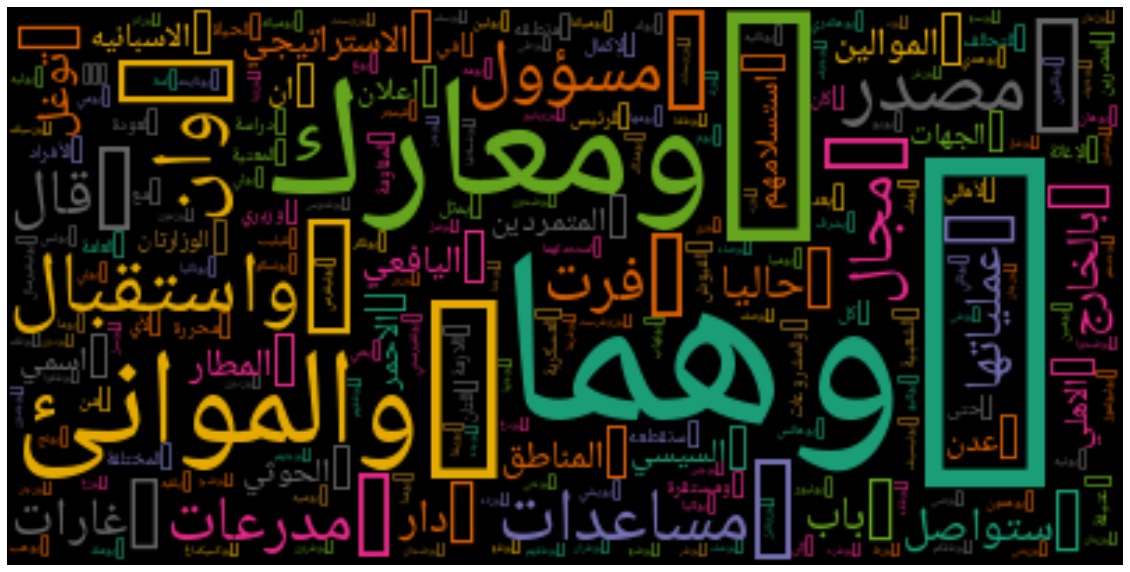

In [42]:
# print WordCloud visualization

awc = ArabicWordCloud(background_color="black",)

mpl.rcParams['figure.figsize']=(20,12.0)  
mpl.rcParams['font.size']=12            
mpl.rcParams['savefig.dpi']=100             
mpl.rcParams['figure.subplot.bottom']=.1 

# wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(
#     str(tfidf.get_feature_names()))

wordcloud = awc.generate(str(tfidf.get_feature_names())).from_text(str(tfidf.get_feature_names()))

print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud.recolor(colormap='Dark2'),interpolation='bilinear')
#plt.title("Word Cloud of all the words")
plt.axis('off')

count of source

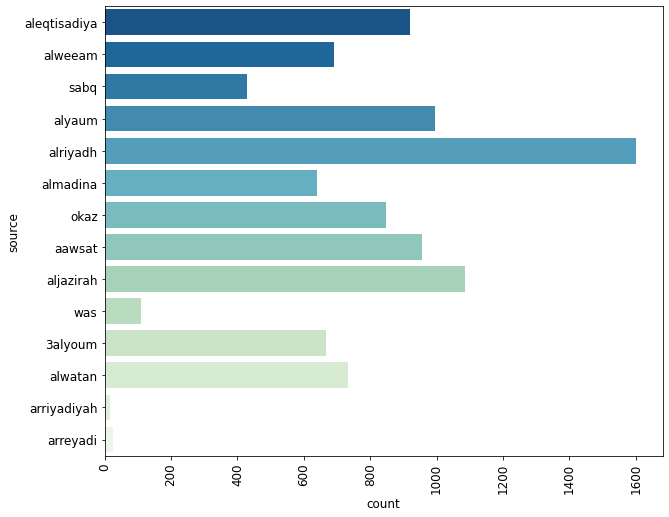

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.countplot(y="source", data=df, palette='GnBu_r');

source Distribution

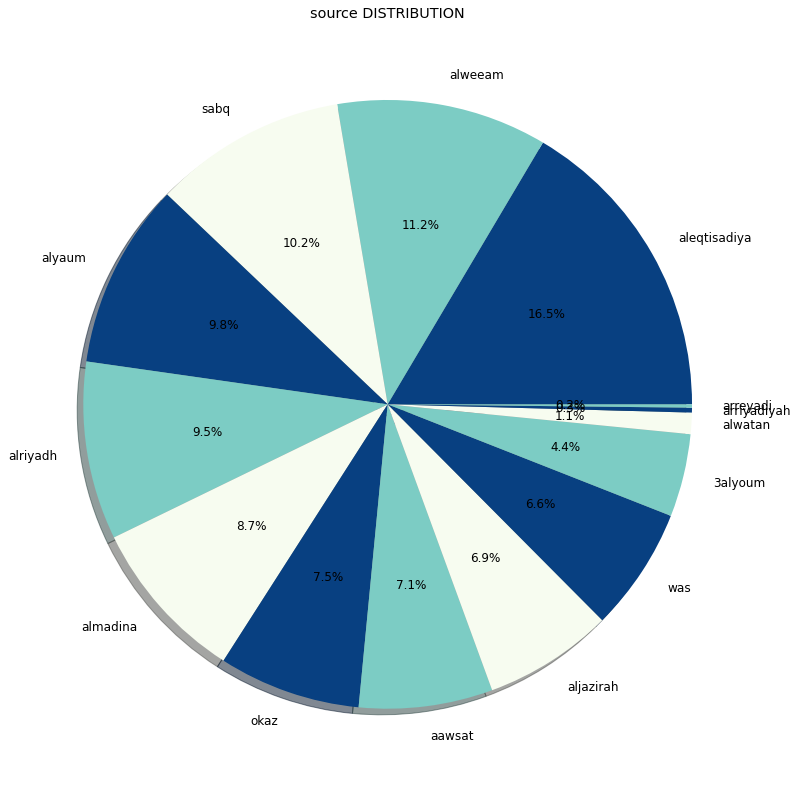

In [44]:
from matplotlib.gridspec import GridSpec
import numpy as np

targetCounts = df['source'].value_counts()
targetLabels  = df['source'].unique()
# Make square figures and axes
plt.figure(1, figsize=(30,30))
the_grid = GridSpec(2, 2)

#Blues_r #PuBuGn #Sequential
cmap = plt.get_cmap('GnBu_r')
colors = [cmap(i) for i in np.linspace(0, 1, 3)]
plt.subplot(the_grid[0, 1], aspect=1, title='source DISTRIBUTION')

source_pie = plt.pie(targetCounts, labels=targetLabels, autopct='%1.1f%%', shadow=True, colors=colors)

In [47]:
# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel

**Topic Modeling**


1. NMF

In [56]:
# function to display topics with words
from sklearn.decomposition import NMF, LatentDirichletAllocation

def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
#         else:
#             print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))
    

def display_top(model, feature_names, no_top_words, topic_names=None):
    
    my_dict = {'topic_0':'','topic_1':'','topic_2':'','topic_3':'','topic_4':''}
    ctr = 0
    for ix, topic in enumerate(model.components_):
                #if not topic_names or not topic_names[ix]:
#             print("\nTopic ", ix)
        txt = ",".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        my_dict['topic_'+str(ctr)] = txt
        ctr+=1
#         print('words are::: ',txt)
    return my_dict

In [57]:
topic_nums = list(np.arange(3, 10, 1))

#nmf_models = []
for num in topic_nums:
    nmf = NMF(num)
    #nmf_models.append(nmf)
    nmf.fit_transform(doc_words)
    display_topics(nmf, tfidf.get_feature_names(), 50)
    print("------------------------------------------")


Topic  0
ان, علي, الي, او, خلال, انه, ايران, العام, العمل, وقال, اكثر, اي, حتي, عام, داعش, الملكه, المتحده, تم, النفط, اليوم, كانت, عد, الماضي, وفي, الا, الاتفاق, السعوديه, المائه, مليون, المنطقه, امس, عدن, بشكل, وزاره, السوق, دول, مليار, انها, يمكن, الحكومه, وان, مدينه, بان, يكون, اله, اخري, بنسبه, فان, المقاومه, وقد

Topic  1
بن, عبدالعزيز, الامير, ولي, سلمان, الملكي, الملك, السمو, اله, الحرمين, محمد, الشريفين, خادم, سعود, وزير, صاحب, العهد, الدكتور, مجلس, ال, رئيس, الوزراء, فيصل, عبداله, عسير, الملكه, منطقه, الدفاع, امير, الانسانيه, لاغاثه, علي, العربيه, خالد, نائب, سموه, السعوديه, والاعمال, نايف, النائب, الهيئه, مركز, اليمني, امس, العامه, اليمن, وصاحب, المركز, معالي, لرئيس

Topic  2
الفريق, النادي, علي, القدم, الاتحاد, الاعبين, الاعب, ان, الموسم, لكره, نادي, الهلال, السعودي, المدرب, النصر, كاس, المباراه, الاول, مباراه, الفني, السوبر, لاعب, فريق, الاهلي, الملعب, المعسكر, الي, الدوري, المقبل, امام, اداره, التدريبات, الكره, دوري, الوديه, مدرب, الانجليزي, الانديه, الجهاز, خلال, لفريق,

In [58]:
nmf_model = NMF(5)
doc_topic = nmf_model.fit_transform(doc_words)

In [59]:
topic_word = pd.DataFrame(nmf_model.components_.round(3),
             index = ["component_1","component_2","component_3","component_4","component_5"],
             columns = tfidf.get_feature_names())
topic_word

,اؤدي,اؤكد,اؤلئك,اؤيد,ائتلاف,ائتلافيه,ائتمانيه,ائمه,اب,ابا,اباء,اباؤهم,ابائه,ابائهم,ابابا,اباتش,اباحسين,اباحي,اباحيا,اباد,اباده,ابار,ابارا,ابارك,اباغسطس,ابالغ,ابان,ابانات,ابانت,ابانمي,اباه,اباها,اباوت,ابت,ابتد,ابتدا,ابتداء,ابتدائي,ابتدائيه,ابتدات,...,ﺑﻌﺪ,ﺑﻤثل,ﺗﻮﻏﻞ,ﺣﺎﻟﻴﺎ,ﺣﺘﻰ,ﺩﺍﺭ,ﺩﺭﺍﺳﺔ,ﺳنقطعه,ﺳﺘﻮﺍﺻﻞ,ﻋﻤﻠﻴﺎﺗﻬﺎ,ﻋﻨﻴﻔﺔ,ﻏﺎﺭﺍﺕ,ﻓﺮﺕ,ﻓﻲ,ﻗﺎﻝ,ﻛﺎﻥ,ﻛﻞ,ﻟﻌﻮﺩﺓ,ﻟﻠﺘﺤﺎﻟﻒ,ﻟﻠﺮﺋﻴﺲ,ﻣنطقه,ﻣﺠﺎﻝ,ﻣﺤﺮﺭﺓ,ﻣﺪﺭﻋﺎﺕ,ﻣﺴﺆﻭﻝ,ﻣﺴﺎﻋﺪﺍﺕ,ﻣﺼﺪﺭ,ﻣﻊ,ﻣﻦ,ﻭان,ﻭﺍﺳﺘﻘﺒﺎﻝ,ﻭﺍﻟﻤﺸروعات,ﻭﺍﻟﻤﻮﺍﻧﺊ,ﻭﺯﻳري,ﻭﻣﺴﺘﻘﺮﺓ,ﻭﻣﻌﺎﺭﻙ,ﻭﻫﻤﺎ,ﻷهالي,ﻷي,ﻹكمال
component_1,0.001,0.001,0.0,0.001,0.001,0.00,0.001,0.000,0.012,0.005,0.002,0.000,0.002,0.001,0.000,0.001,0.000,0.001,0.001,0.001,0.000,0.003,0.000,0.001,0.002,0.001,0.008,0.003,0.000,0.000,0.001,0.0,0.0,0.002,0.001,0.0,0.014,0.002,0.002,0.002,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.001,0.002
component_2,0.000,0.000,0.0,0.000,0.000,0.00,0.000,0.002,0.000,0.001,0.000,0.003,0.002,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_3,0.000,0.004,0.0,0.000,0.000,0.00,0.000,0.000,0.010,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.003,0.000,0.002,0.000,0.005,0.007,0.000,0.0,0.0,0.000,0.000,0.0,0.007,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
component_4,0.000,0.001,0.0,0.000,0.006,0.01,0.000,0.000,0.027,0.000,0.000,0.000,0.000,0.000,0.009,0.000,0.000,0.000,0.000,0.006,0.004,0.000,0.001,0.000,0.002,0.000,0.005,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.000,0.000,0.001,0.000,...,0.003,0.0,0.003,0.002,0.002,0.002,0.001,0.0,0.002,0.002,0.002,0.002,0.002,0.006,0.003,0.001,0.002,0.002,0.002,0.003,0.002,0.002,0.002,0.003,0.003,0.002,0.003,0.002,0.005,0.002,0.002,0.001,0.002,0.001,0.002,0.002,0.001,0.000,0.001,0.000
component_5,0.000,0.003,0.0,0.000,0.000,0.00,0.003,0.000,0.018,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.001,0.004,0.000,0.000,0.000,0.003,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.000,0.0,0.004,0.000,0.000,0.000,...,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [60]:
display_topics(nmf_model, tfidf.get_feature_names(), 50)



Topic  0
علي, ان, الي, او, العمل, خلال, انه, العامه, تم, الملكه, التعليم, حتي, اله, الا, عد, وزاره, اي, العام, البلديه, الوزاره, الجنه, اكثر, عام, يكون, العيد, وان, كانت, وقد, الانتخابيه, احد, يمكن, وذلك, عكاظ, وفي, واوضح, المجتمع, منطقه, تكون, المنطقه, بشكل, وهي, عليها, عبر, الخدمات, الرياض, يتم, الهيئه, مكه, والتي, جده

Topic  1
بن, عبدالعزيز, الامير, ولي, سلمان, الملكي, السمو, الملك, الحرمين, الشريفين, اله, محمد, خادم, سعود, وزير, صاحب, العهد, مجلس, ال, الدكتور, رئيس, فيصل, الوزراء, عبداله, عسير, امير, الدفاع, لاغاثه, العربيه, الملكه, الانسانيه, منطقه, نائب, سموه, خالد, والاعمال, السعوديه, نايف, النائب, وصاحب, الثاني, المركز, معالي, امس, لرئيس, جمهوريه, الفيصل, حفظه, مركز, العام

Topic  2
الفريق, النادي, علي, الاتحاد, القدم, الاعبين, الاعب, الموسم, ان, لكره, نادي, الهلال, السعودي, المدرب, النصر, كاس, المباراه, مباراه, الاول, الفني, السوبر, لاعب, الاهلي, الملعب, فريق, المعسكر, الدوري, الي, امام, المقبل, التدريبات, اداره, الكره, الوديه, دوري, الانجليزي, مدرب, الجهاز, لفريق, الانديه, 

2. LDA

In [61]:
# Define Search Param
search_params = {'n_components': [10, 9, 8, 7, 6, 5, 4, 3], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(doc_words)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [10, 9, 8, 7, 6, 5, 4, 3]})

In [62]:
from sklearn.decomposition import LatentDirichletAllocation

# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(doc_words))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 3}
Best Log Likelihood Score:  -84695.4612516417
Model Perplexity:  132941.59290727295


In [63]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(doc_words)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(10).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,dominant_topic
Doc0,0.930000,0.040000,0.030000,0
Doc1,0.200000,0.780000,0.020000,1
Doc2,0.940000,0.030000,0.030000,0
Doc3,0.940000,0.030000,0.030000,0
Doc4,0.930000,0.030000,0.030000,0
Doc5,0.930000,0.040000,0.030000,0
Doc6,0.100000,0.880000,0.020000,1
Doc7,0.030000,0.950000,0.020000,1
Doc8,0.940000,0.030000,0.030000,0
Doc9,0.940000,0.030000,0.030000,0
